In [91]:
import os
import cv2
import numpy as np
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import KernelPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC

In [92]:
# Function to load the MSTAR dataset and resize to 128 * 128
def get_MSTAR(train_dir, val_dir, test_dir):
    def load_images_from_folder(folder):
        images = []
        labels = []
        for label in os.listdir(folder):
            label_folder = os.path.join(folder, label)
            if os.path.isdir(label_folder):
                for filename in os.listdir(label_folder):
                    img_path = os.path.join(label_folder, filename)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        # Resize image to 128x128
                        img_resized = cv2.resize(img, (128, 128))
                        images.append(img_resized)
                        labels.append(label)
        return np.array(images), np.array(labels)

    X_train, y_train = load_images_from_folder(train_dir)
    X_val, y_val = load_images_from_folder(val_dir)
    X_test, y_test = load_images_from_folder(test_dir)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

    # Convert lists to numpy arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_val = np.array(X_val)
    y_val = np.array(y_val)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    return X_train, y_train, X_val, y_val, X_test, y_test
    
# Function to display trained, validated, and tested sets
def display_class_counts(y_train, y_val, y_test):
    train_counts = Counter(y_train)
    val_counts = Counter(y_val)
    test_counts = Counter(y_test)
    classes = sorted(set(train_counts.keys()).union(set(val_counts.keys()).union(set(test_counts.keys()))))
    print(f"{'Class':<10} {'Train Count':<12} {'Val Count':<12} {'Test Count':<10}")
    print("="*44)
    for cls in classes:
        train_count = train_counts.get(cls, 0)
        val_count = val_counts.get(cls, 0)
        test_count = test_counts.get(cls, 0)
        print(f"{cls:<10} {train_count:<12} {val_count:<12} {test_count:<10}")

# Path to the training, validation, and testing datasets
train_dir = '/home/nathan/Documents/EEE4022S/New/DATASET/TRAIN'
val_dir = '/home/nathan/Documents/EEE4022S/New/DATASET/VAL'
test_dir = '/home/nathan/Documents/EEE4022S/New/DATASET/TEST'


In [93]:

# Dataset loading
X_train, y_train, X_val, y_val, X_test, y_test = get_MSTAR(train_dir, val_dir, test_dir)
display_class_counts(y_train, y_val, y_test)

Class      Train Count  Val Count    Test Count
2S1        230          80           141       
BRDM_2     230          80           141       
BTR_60     230          80           141       
D7         230          80           141       
SLICY      230          80           141       
T62        230          80           141       
ZIL131     230          80           141       
ZSU_23_4   230          80           141       


In [28]:
def flatten_images(images):
    return np.array([img.flatten() for img in images])

X_train_flat = flatten_images(X_train)
X_val_flat = flatten_images(X_val)
X_test_flat = flatten_images(X_test)

# Standardize data
scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_val_flat = scaler.transform(X_val_flat)
X_test_flat = scaler.transform(X_test_flat)


In [29]:
def plot_kpca_explained_variance(kpca):
    plt.figure(figsize=(8, 4))
    plt.plot(np.cumsum(kpca.eigenvalues_ / np.sum(kpca.eigenvalues_)))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('Explained Variance Ratio (KPCA)')
    plt.grid(True)
    plt.show()

def plot_scree(kpca):
    plt.figure(figsize=(8, 4))
    plt.plot(kpca.eigenvalues_, marker='o', linestyle='--')
    plt.xlabel('Component')
    plt.ylabel('Eigenvalue')
    plt.title('Scree Plot (KPCA)')
    plt.grid(True)
    plt.show()

def plot_biplot(X, labels):
    plt.figure(figsize=(10, 8))
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=10)
    plt.xlabel('KPCA 1')
    plt.ylabel('KPCA 2')
    plt.title('KPCA Biplot')
    plt.grid(True)
    plt.show()


In [86]:
# Apply Kernel PCA with polynomial kernel
kpca = KernelPCA(n_components=40, kernel='poly', degree=2, random_state=42)
X_train_kpca = kpca.fit_transform(X_train_flat)
X_test_kpca = kpca.transform(X_test_flat)
X_val_pca = kpca.transform(X_val_flat)

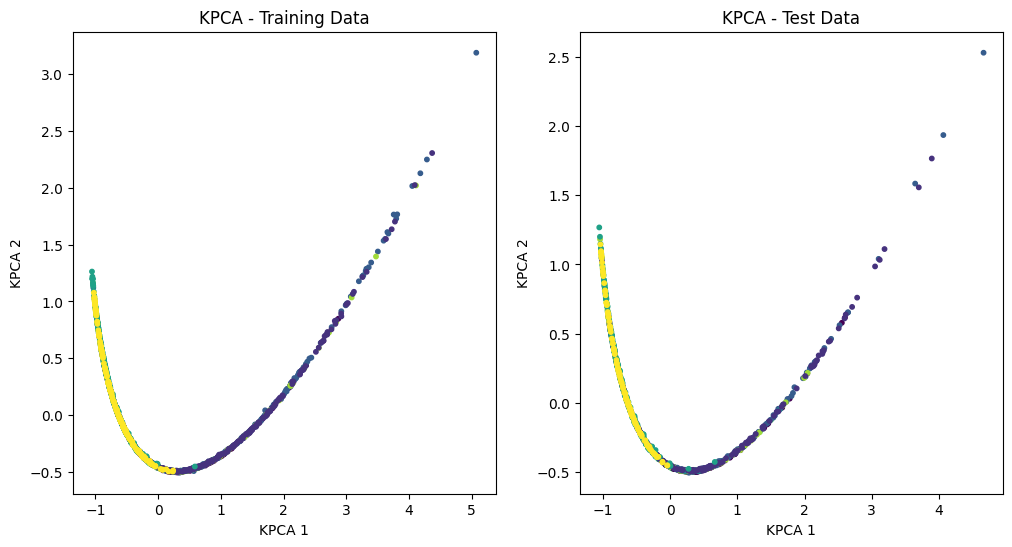

In [87]:
# Plot KPCA results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_train_kpca[:, 0], X_train_kpca[:, 1], c=LabelEncoder().fit_transform(y_train), cmap='viridis', s=10)
plt.title('KPCA - Training Data')
plt.xlabel('KPCA 1')
plt.ylabel('KPCA 2')
plt.subplot(1, 2, 2)
plt.scatter(X_test_kpca[:, 0], X_test_kpca[:, 1], c=LabelEncoder().fit_transform(y_test), cmap='viridis', s=10)
plt.title('KPCA - Test Data')
plt.xlabel('KPCA 1')
plt.ylabel('KPCA 2')
plt.show()

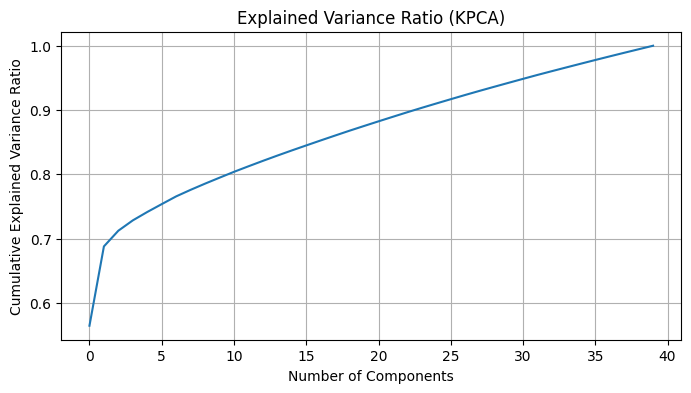

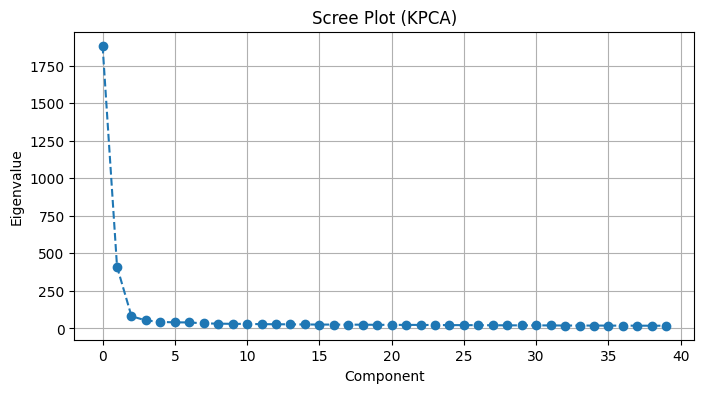

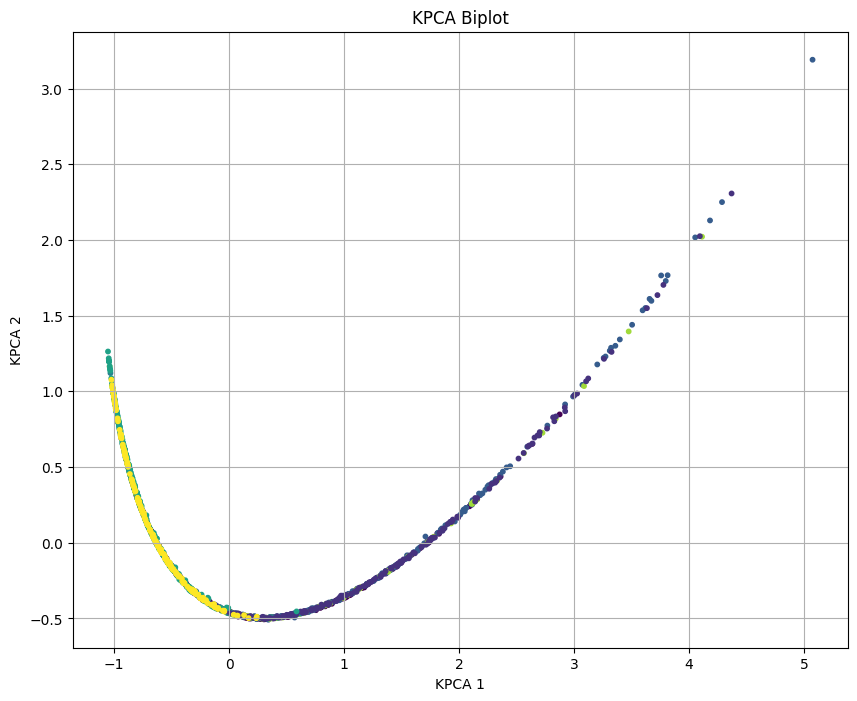

In [88]:
# Additional plots
plot_kpca_explained_variance(kpca)
plot_scree(kpca)
plot_biplot(X_train_kpca, LabelEncoder().fit_transform(y_train))

Classification Report:
              precision    recall  f1-score   support

         2S1       0.71      0.73      0.72       141
      BRDM_2       0.79      0.63      0.70       141
      BTR_60       0.83      0.72      0.77       141
          D7       0.75      0.85      0.80       141
       SLICY       1.00      0.99      0.99       141
         T62       0.77      0.80      0.78       141
      ZIL131       0.70      0.77      0.73       141
    ZSU_23_4       0.80      0.84      0.82       141

    accuracy                           0.79      1128
   macro avg       0.79      0.79      0.79      1128
weighted avg       0.79      0.79      0.79      1128

Accuracy: 0.79
Precision: 0.79
Recall: 0.79
F1 Score: 0.79


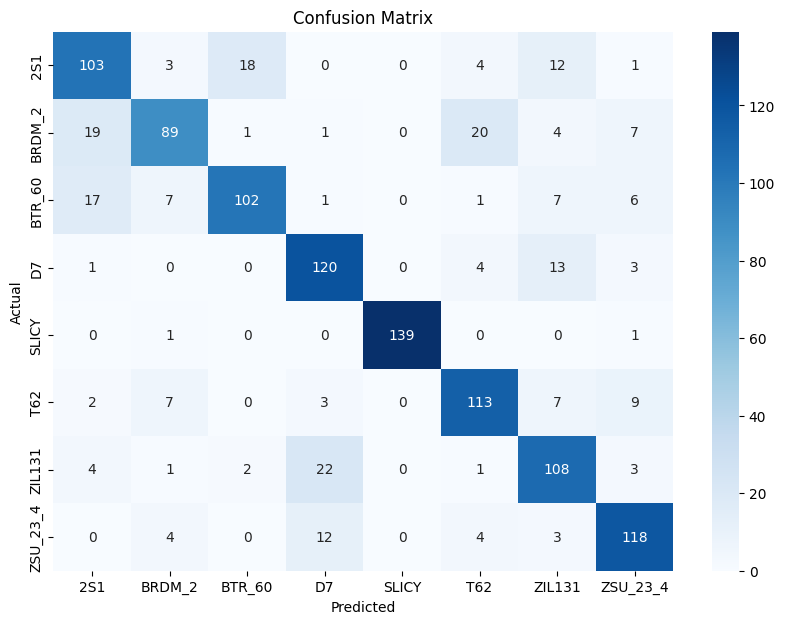

In [89]:
# Train a k-NN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_kpca, y_train)
y_pred = knn.predict(X_test_kpca)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=np.unique(y_test)))

# Print individual metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

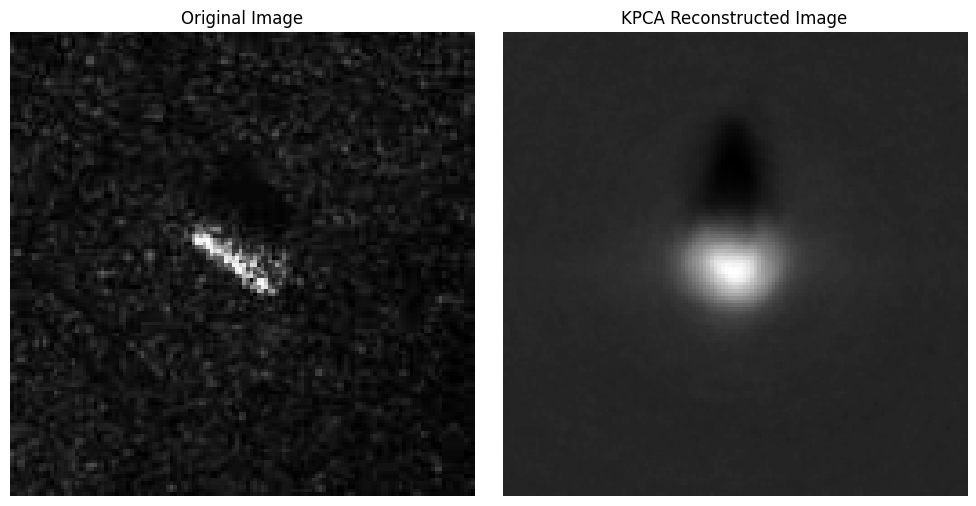

In [107]:

# Redefine KPCA with fit_inverse_transform=True
kpca = KernelPCA(n_components=40, kernel='poly', degree=2, fit_inverse_transform=True, random_state=42)
X_train_kpca = kpca.fit_transform(X_train_flat)
X_test_kpca = kpca.transform(X_test_flat)
X_val_kpca = kpca.transform(X_val_flat)

# Choose an image index to visualize
image_index = 20

# Get the original image and its KPCA transformation
original_image = X_train[image_index]
kpca_image = X_train_kpca[image_index]

# Reconstruct the image from KPCA components
reconstructed_flat = kpca.inverse_transform([kpca_image])
reconstructed_image = scaler.inverse_transform(reconstructed_flat).reshape(128, 128)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(original_image, cmap='gray')
ax1.set_title('Original Image')
ax1.axis('off')

ax2.imshow(reconstructed_image, cmap='gray')
ax2.set_title('KPCA Reconstructed Image')
ax2.axis('off')

plt.tight_layout()
plt.show()
